Connection String To Mongo Db and Postgres

In [147]:
# Common imports for both tasks
import pandas as pd
import requests
from pymongo import MongoClient
from psycopg2 import extras
import psycopg2
import xml.etree.ElementTree as ET
from itertools import islice
from concurrent.futures import ThreadPoolExecutor
import luigi

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
"host": "localhost",
"database": "postgres",
"user": "postgres",
"password": "Thanksgiving2024"
}


Pushing XML & CSV Data to MongoDb

In [148]:
import requests
import pandas as pd
from pymongo import MongoClient
import xml.etree.ElementTree as ET
from itertools import islice
from concurrent.futures import ThreadPoolExecutor

# MongoDB connection URI
mongo_uri = "mongodb://localhost:27017/"

# Function to fetch XML data from the URL
def fetch_xml_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.content
    else:
        print("Failed to fetch XML data")
        return None

# Function to parse XML data and insert into MongoDB
def insert_xml_to_mongodb(records, collection_name):
    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]

    collection.insert_many(records)
    client.close()
    print(f"{len(records)} records inserted into MongoDB.")

# Function to process XML data and store in MongoDB
def process_and_store_data(xml_data, collection_name, limit):
    root = ET.fromstring(xml_data)
    records = []
    for row in islice(root.iter('row'), limit):
        data = {}
        for child in row:
            data[child.tag] = child.text
        records.append(data)
    insert_xml_to_mongodb(records, collection_name)

# Function to handle data fetching and processing concurrently
def handle_data(url, collection_name, limit):
    xml_data = fetch_xml_data(url)
    if xml_data:
        process_and_store_data(xml_data, collection_name, limit)
        print("Data processing and insertion completed.")
    else:
        print("Failed to process data.")

# Function to read and insert CSV data into MongoDB
def insert_csv_to_mongodb(csv_file_path, collection_name):
    data = pd.read_csv(csv_file_path)
    data_dict = data.to_dict("records")

    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]

    try:
        collection.insert_many(data_dict)
        print("CSV data inserted successfully into MongoDB.")
    except Exception as e:
        print(f"An error occurred while inserting CSV data: {e}")
    finally:
        client.close()

# Main function to execute the process
def main():
    tasks = [
        ("https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.xml?accessType=DOWNLOAD", "CrashReporting", 1500)
    ]

    csv_task = ('Traffic_Crashes_-_Crashes.csv', 'TrafficCrashes')

    with ThreadPoolExecutor(max_workers=3) as executor:
        for url, collection_name, limit in tasks:
            executor.submit(handle_data, url, collection_name, limit)
        executor.submit(insert_csv_to_mongodb, *csv_task)

if __name__ == "__main__":
    main()

1500 records inserted into MongoDB.
Data processing and insertion completed.
CSV data inserted successfully into MongoDB.


IMPORT FOR MOTOR VEHICLE COLLISIONS

In [149]:
import requests
from pymongo import MongoClient
import xml.etree.ElementTree as ET
from io import BytesIO

mongo_uri = "mongodb://localhost:27017/"

# Function to fetch XML data from the URL
def fetch_xml_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        print("Failed to fetch XML data")
        return None


def insert_xml_to_mongodb(records, collection_name):
    client = MongoClient(mongo_uri)
    db = client.DatabaseAnalytics
    collection = db[collection_name]

    collection.insert_many(records)
    print(f"{len(records)} records inserted into MongoDB.")
    client.close()

# Process XML data and store in MongoDB
def process_and_store_data(xml_data, collection_name, limit):
    records = []
    root = ET.iterparse(xml_data)
    for event, elem in root:
        if elem.tag == 'row':
            record = {}
            for child in elem:
                record[child.tag] = child.text
            records.append(record)
            if len(records) >= limit:
                break

    insert_xml_to_mongodb(records, collection_name)

# Main function to execute the process
def main():
    xml_url = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.xml?accessType=DOWNLOAD"
    collection_name = "MotorVehicleCollisions"
    limit = 1500
    xml_data = fetch_xml_data(xml_url)
    if xml_data:
        process_and_store_data(xml_data, collection_name, limit)
        print("Data insertion completed.")
    else:
        print("Failed to insert data into MongoDB.")

if __name__ == "__main__":
    main()


1500 records inserted into MongoDB.
Data insertion completed.


LUIGI ETL PROCESS FROM MONGODB TO POSTGRESS

In [150]:
import luigi
import psycopg2
import pandas as pd
import numpy as np
from pymongo import MongoClient
from psycopg2 import extras
from luigi import LocalTarget

# MongoDB and PostgreSQL connection parameters
mongo_uri = "mongodb://localhost:27017/"
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

class FetchDataFromMongo(luigi.Task):
    collection_name = luigi.Parameter()
    
    def output(self):
        # Define a normal output path
        return LocalTarget(f"data_{self.collection_name}.csv")
    
    def run(self):
        print(f"Fetching data from MongoDB for collection: {self.collection_name}")
        client = MongoClient(mongo_uri)
        db = client.DatabaseAnalytics
        collection = db[self.collection_name]
        data = pd.DataFrame(list(collection.find().limit(1300)))
        client.close()
        
        data.to_csv(self.output().path, index=False)

class TransformData(luigi.Task):
    collection_name = luigi.Parameter()
    
    def requires(self):
        return FetchDataFromMongo(self.collection_name)
    
    def output(self):
        return LocalTarget(f"transformed_data_{self.collection_name}.csv")
    
    def run(self):
        print(f"Transforming data for collection: {self.collection_name}")
        df = pd.read_csv(self.input().path)
        
        if '_id' in df.columns:
            df['_id'] = df['_id'].astype(str)
        df.fillna(value=np.nan, inplace=True)
        df.replace({np.nan: None}, inplace=True)
        
        df.to_csv(self.output().path, index=False)

class LoadDataToPostgres(luigi.Task):
    collection_name = luigi.Parameter()
    table_name = luigi.Parameter()

    def requires(self):
        return TransformData(self.collection_name)
    
    def output(self):
        return LocalTarget(f"{self.table_name}_load_done.txt")
    
    def run(self):
        print(f"Loading data to PostgreSQL for table: {self.table_name}")
        df = pd.read_csv(self.input().path)
        conn = psycopg2.connect(**pg_params)
        cur = conn.cursor()
        try:
            cur.execute(f"DROP TABLE IF EXISTS {self.table_name};")
            sql_create_table = f"CREATE TABLE {self.table_name} ("
            column_definitions = []
            for column, dtype in zip(df.columns, df.dtypes):
                sql_type = "TEXT"
                if "int" in str(dtype):
                    sql_type = "INTEGER"
                elif "float" in str(dtype):
                    sql_type = "NUMERIC"
                elif "datetime" in str(dtype):
                    sql_type = "TIMESTAMP"
                column_definitions.append(f"{column} {sql_type}")
            sql_create_table += ", ".join(column_definitions) + ");"
            cur.execute(sql_create_table)

            columns = list(df.columns)
            sql = f"INSERT INTO {self.table_name} ({', '.join(columns)}) VALUES %s"
            tuples = [tuple(x) for x in df.to_numpy()]
            extras.execute_values(cur, sql, tuples)
            conn.commit()
            
            with self.output().open('w') as f:
                f.write('Data load complete')
        except Exception as e:
            print(f"An error occurred: {e}")
        finally:
            cur.close()
            conn.close()

class MongoToPostgresPipeline(luigi.WrapperTask):
    def requires(self):
        collections_to_tables = {
            "CrashReporting": "crash_reporting",
            "TrafficCrashes": "traffic_crashes",
            "MotorVehicleCollisions": "motor_vehicle_collisions"
        }
        
        for collection_name, table_name in collections_to_tables.items():
            yield LoadDataToPostgres(collection_name=collection_name, table_name=table_name)

if __name__ == "__main__":
    luigi.build([MongoToPostgresPipeline()], local_scheduler=True)


DEBUG: Checking if MongoToPostgresPipeline() is complete
INFO: Informed scheduler that task   MongoToPostgresPipeline__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=9932695033, workers=1, host=LynettPC, username=lynne, pid=57240) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 MongoToPostgresPipeline()

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



Visualizations - Crash Reporting

In [151]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

conn = psycopg2.connect(**pg_params)
warnings.filterwarnings("ignore")
# Query data from the crash_reporting table
query = "SELECT * FROM crash_reporting;"
new_data = pd.read_sql(query, conn)

conn.close()
# Saving the DataFrame to a CSV file
csv_file_path = 'crash_reporting_data.csv'
new_data.to_csv(csv_file_path, index=False)

Descriptive Analysis Below

In [152]:
data = pd.read_csv(csv_file_path)
# Display the first few rows of the data
print(data.head())

# Display basic statistics of numerical columns
print(data.describe())


                        _id  row report_number  local_case_number  \
0  6632727894e19703538698aa  NaN           NaN                NaN   
1  6632727894e19703538698ab  NaN   MCP3040003N        190026050.0   
2  6632727894e19703538698ac  NaN    EJ78850038        230034791.0   
3  6632727894e19703538698ad  NaN   MCP2009002G        230034583.0   
4  6632727894e19703538698ae  NaN   MCP3201004C        230035036.0   

                 agency_name       acrs_report_type      crash_date_time  \
0                        NaN                    NaN                  NaN   
1   Montgomery County Police  Property Damage Crash  2019-05-31T15:00:00   
2  Gaithersburg Police Depar  Property Damage Crash  2023-07-21T17:59:00   
3   Montgomery County Police  Property Damage Crash  2023-07-20T15:10:00   
4   Montgomery County Police  Property Damage Crash  2023-07-23T12:10:00   

             off_road_description           collision_type weather  ...  \
0                             NaN                    

In [153]:
# Display information about the DataFrame structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             1300 non-null   object 
 1   row                             0 non-null      float64
 2   report_number                   1299 non-null   object 
 3   local_case_number               1299 non-null   float64
 4   agency_name                     1299 non-null   object 
 5   acrs_report_type                1299 non-null   object 
 6   crash_date_time                 1299 non-null   object 
 7   off_road_description            133 non-null    object 
 8   collision_type                  1297 non-null   object 
 9   weather                         1207 non-null   object 
 10  light                           1287 non-null   object 
 11  traffic_control                 1144 non-null   object 
 12  driver_substance_abuse          10

In [154]:
# Calculate the sum of missing values in each column
missing_values = data.isna().sum()

# Display the sum of missing values
print(missing_values)

_id                                  0
row                               1300
report_number                        1
local_case_number                    1
agency_name                          1
acrs_report_type                     1
crash_date_time                      1
off_road_description              1167
collision_type                       3
weather                             93
light                               13
traffic_control                    156
driver_substance_abuse             244
person_id                            1
driver_at_fault                      1
injury_severity                      1
circumstance                      1151
driver_distracted_by                 1
vehicle_id                           1
vehicle_damage_extent                7
vehicle_first_impact_location        1
vehicle_second_impact_location       1
vehicle_body_type                   22
vehicle_movement                     6
vehicle_continuing_dir              24
vehicle_going_dir        

In [155]:
# Check for missing values in the DataFrame
missing_values = data.isnull().sum()

# Handle missing values for numerical columns
numerical_columns = data.select_dtypes(include='number')
mean_values = numerical_columns.mean()
data.fillna(mean_values, inplace=True)

# Handle missing values for categorical columns
categorical_columns = data.select_dtypes(exclude='number').columns
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

# Check if there are any missing values after handling them
missing_values_after_handling = data.isnull().sum()
if missing_values_after_handling.sum() > 0:
    print("There are still missing values in the DataFrame:")
    print(missing_values_after_handling)
else:
    print("No missing values in the DataFrame after handling.")


There are still missing values in the DataFrame:
_id                                  0
row                               1300
report_number                        0
local_case_number                    0
agency_name                          0
acrs_report_type                     0
crash_date_time                      0
off_road_description                 0
collision_type                       0
weather                              0
light                                0
traffic_control                      0
driver_substance_abuse               0
person_id                            0
driver_at_fault                      0
injury_severity                      0
circumstance                         0
driver_distracted_by                 0
vehicle_id                           0
vehicle_damage_extent                0
vehicle_first_impact_location        0
vehicle_second_impact_location       0
vehicle_body_type                    0
vehicle_movement                     0
vehicle_continu

In [156]:
# List of columns to remove
columns_to_remove = ['_id', 'row', 'off_road_description', 'circumstance', 'non_motorist_substance_abuse']


data = data.drop(columns=columns_to_remove, errors='ignore')

In [157]:
# Calculate the sum of missing values in each column
final_missing_values = data.isna().sum()

# Display the sum of missing values
print(final_missing_values)

report_number                        0
local_case_number                    0
agency_name                          0
acrs_report_type                     0
crash_date_time                      0
collision_type                       0
weather                              0
light                                0
traffic_control                      0
driver_substance_abuse               0
person_id                            0
driver_at_fault                      0
injury_severity                      0
driver_distracted_by                 0
vehicle_id                           0
vehicle_damage_extent                0
vehicle_first_impact_location        0
vehicle_second_impact_location       0
vehicle_body_type                    0
vehicle_movement                     0
vehicle_continuing_dir               0
vehicle_going_dir                    0
speed_limit                          0
driverless_vehicle                   0
parked_vehicle                       0
vehicle_year             

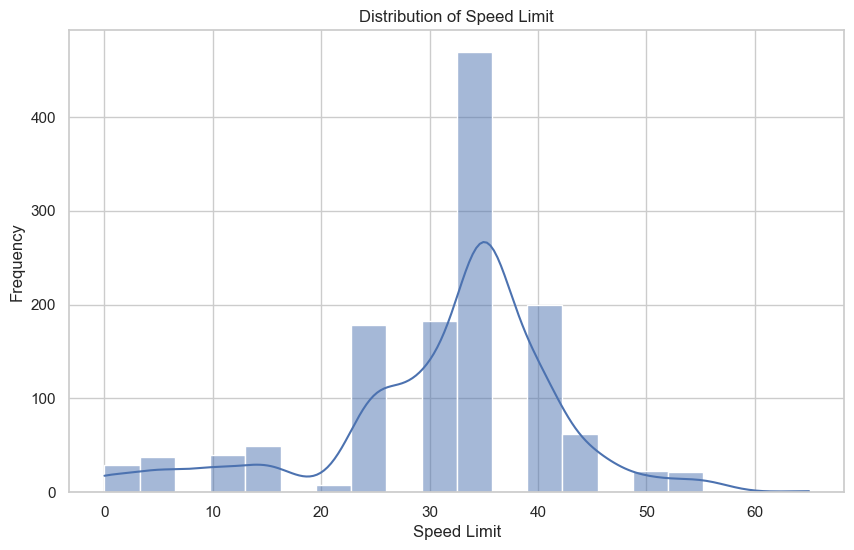

In [159]:
# histogram for numerical variables
plt.figure(figsize=(10, 6))
sns.histplot(data['speed_limit'], bins=20, kde=True)
plt.title('Distribution of Speed Limit')
plt.xlabel('Speed Limit')
plt.ylabel('Frequency')
plt.show()

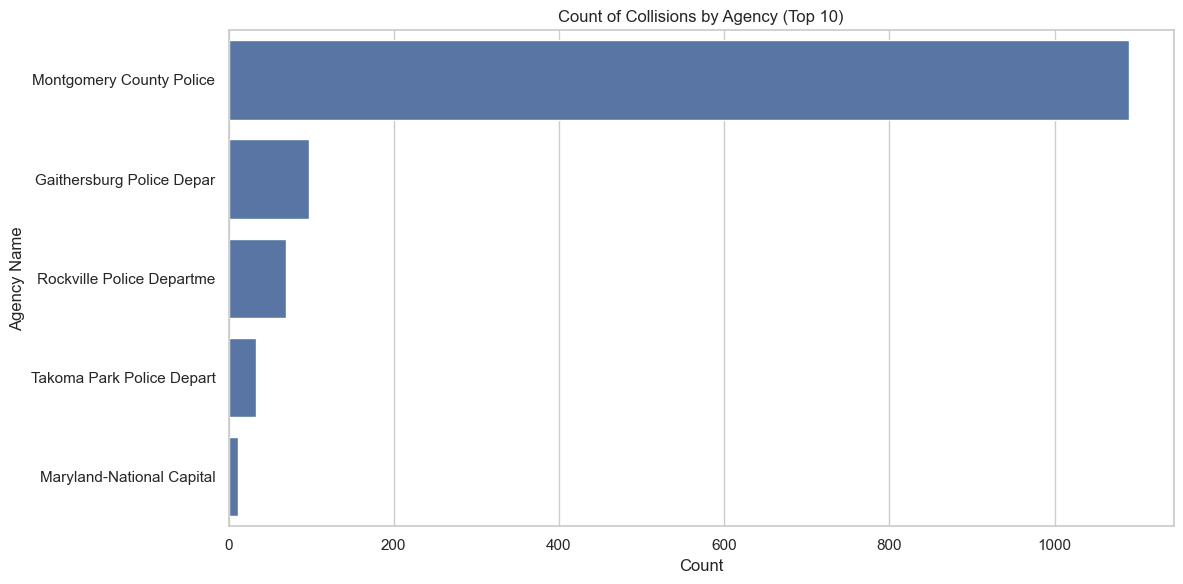

In [160]:
# Count of Collisions by Agency
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='agency_name', order=data['agency_name'].value_counts().index[:10])
plt.title('Count of Collisions by Agency (Top 5)')
plt.xlabel('Count')
plt.ylabel('Agency Name')
plt.tight_layout()
plt.show()

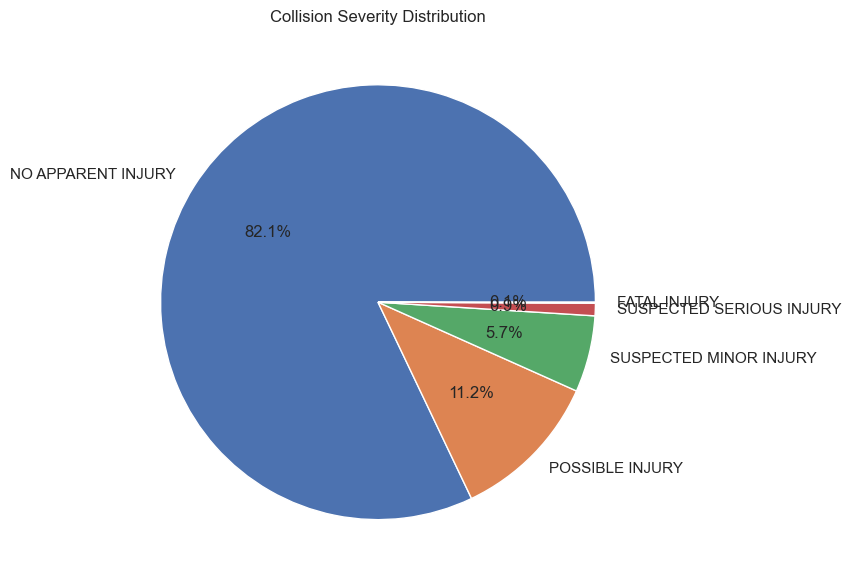

In [161]:
plt.figure(figsize=(8, 6))
data['injury_severity'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Collision Severity Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

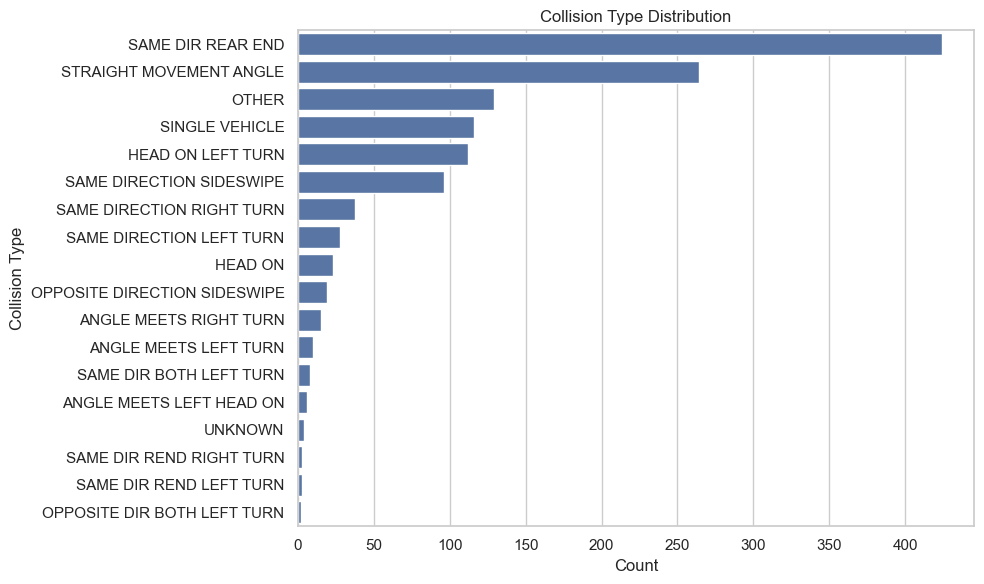

In [162]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='collision_type', order=data['collision_type'].value_counts().index)
plt.title('Collision Type Distribution')
plt.xlabel('Count')
plt.ylabel('Collision Type')
plt.tight_layout()
plt.show()

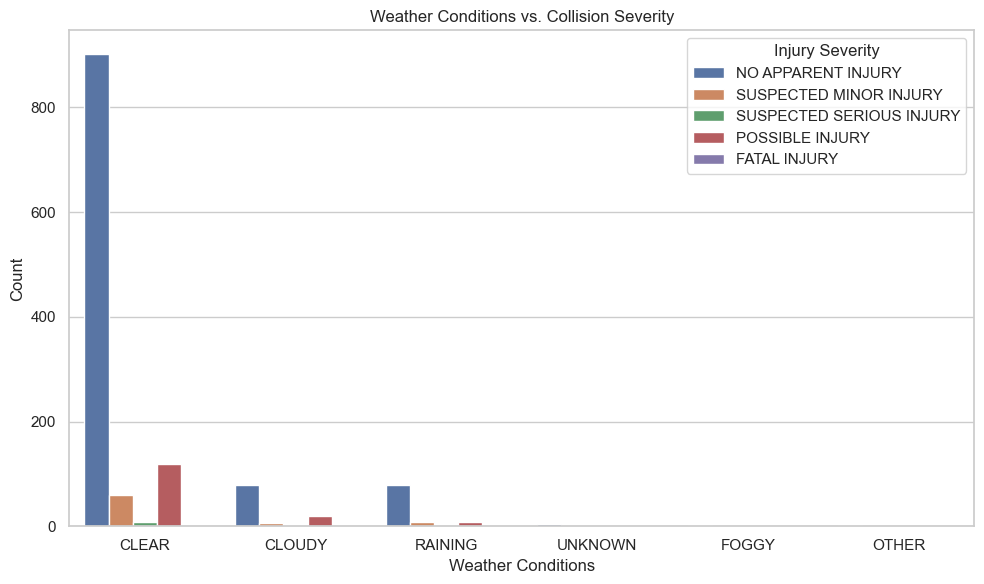

In [163]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='weather', hue='injury_severity')
plt.title('Weather Conditions vs. Collision Severity')
plt.xlabel('Weather Conditions')
plt.ylabel('Count')
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()

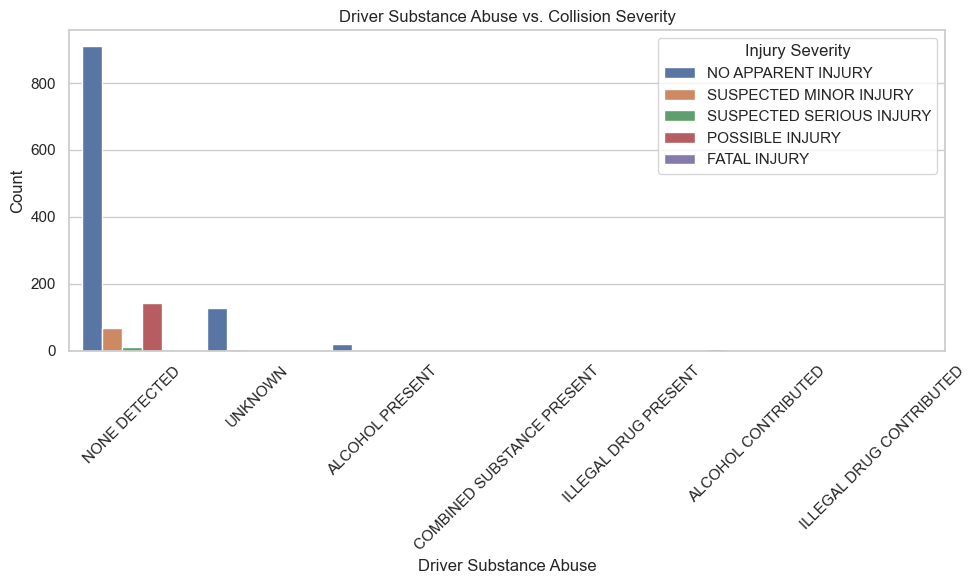

In [164]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='driver_substance_abuse', hue='injury_severity')
plt.title('Driver Substance Abuse vs. Collision Severity')
plt.xlabel('Driver Substance Abuse')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()

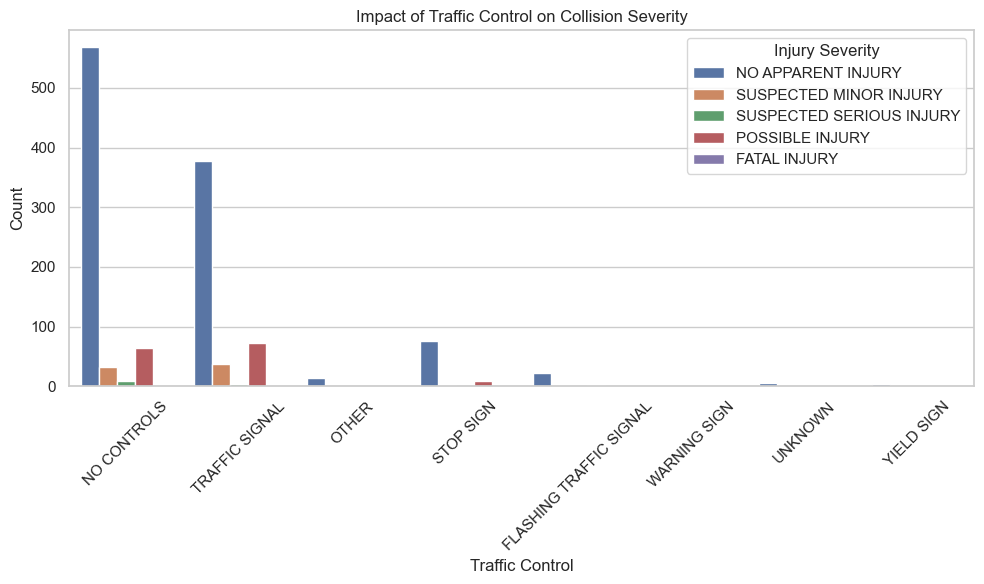

In [165]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='traffic_control', hue='injury_severity')
plt.title('Impact of Traffic Control on Collision Severity')
plt.xlabel('Traffic Control')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Injury Severity')
plt.show()

Visualizations - Traffic Crashes

In [166]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

conn = psycopg2.connect(**pg_params)
warnings.filterwarnings("ignore")
# Query data from the traffic_crashes table
query = "SELECT * FROM traffic_crashes;"
new_traffic_data = pd.read_sql(query, conn)

conn.close()
# Saving the DataFrame to a CSV file
csv_file_path = 'traffic_crashes.csv'
new_traffic_data.to_csv(csv_file_path, index=False)

In [167]:
data = pd.read_csv(csv_file_path)
# Display the first few rows of the data
print(data.head())

# Display basic statistics of numerical columns
print(data.describe())


                        _id  \
0  6632726494e19703537a0c76   
1  6632726494e19703537a0c77   
2  6632726494e19703537a0c78   
3  6632726494e19703537a0c79   
4  6632726494e19703537a0c7a   

                                     crash_record_id crash_date_est_i  \
0  23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...              NaN   
1  2675c13fd0f474d730a5b780968b3cafc7c12d7adb661f...              NaN   
2  5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...              NaN   
3  7ebf015016f83d09b321afd671a836d6b148330535d5df...              NaN   
4  6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...              NaN   

               crash_date  posted_speed_limit traffic_control_device  \
0  09/05/2023 07:05:00 PM                  30         TRAFFIC SIGNAL   
1  09/22/2023 06:45:00 PM                  50            NO CONTROLS   
2  07/29/2023 02:45:00 PM                  30         TRAFFIC SIGNAL   
3  08/09/2023 11:00:00 PM                  30            NO CONTROLS   
4  08/18/2023 

In [168]:
# Display information about the DataFrame structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            1300 non-null   object 
 1   crash_record_id                1300 non-null   object 
 2   crash_date_est_i               80 non-null     object 
 3   crash_date                     1300 non-null   object 
 4   posted_speed_limit             1300 non-null   int64  
 5   traffic_control_device         1300 non-null   object 
 6   device_condition               1300 non-null   object 
 7   weather_condition              1300 non-null   object 
 8   lighting_condition             1300 non-null   object 
 9   first_crash_type               1300 non-null   object 
 10  trafficway_type                1300 non-null   object 
 11  lane_cnt                       172 non-null    float64
 12  alignment                      1300 non-null   o

In [169]:
# Check for missing values in the DataFrame
missing_values = data.isnull().sum()

# Handle missing values for numerical columns
numerical_columns = data.select_dtypes(include='number')
mean_values = numerical_columns.mean()
data.fillna(mean_values, inplace=True)

# Handle missing values for categorical columns
categorical_columns = data.select_dtypes(exclude='number').columns
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

# Check if there are any missing values after handling them
missing_values_after_handling = data.isnull().sum()
if missing_values_after_handling.sum() > 0:
    print("There are still missing values in the DataFrame:")
    print(missing_values_after_handling)
else:
    print("No missing values in the DataFrame after handling.")


No missing values in the DataFrame after handling.


In [170]:
# Calculate the sum of missing values in each column
traffic_missing_values = data.isna().sum()

# Display the sum of missing values
print(traffic_missing_values)

_id                              0
crash_record_id                  0
crash_date_est_i                 0
crash_date                       0
posted_speed_limit               0
traffic_control_device           0
device_condition                 0
weather_condition                0
lighting_condition               0
first_crash_type                 0
trafficway_type                  0
lane_cnt                         0
alignment                        0
roadway_surface_cond             0
road_defect                      0
report_type                      0
crash_type                       0
intersection_related_i           0
not_right_of_way_i               0
hit_and_run_i                    0
damage                           0
date_police_notified             0
prim_contributory_cause          0
sec_contributory_cause           0
street_no                        0
street_direction                 0
street_name                      0
beat_of_occurrence               0
photos_taken_i      

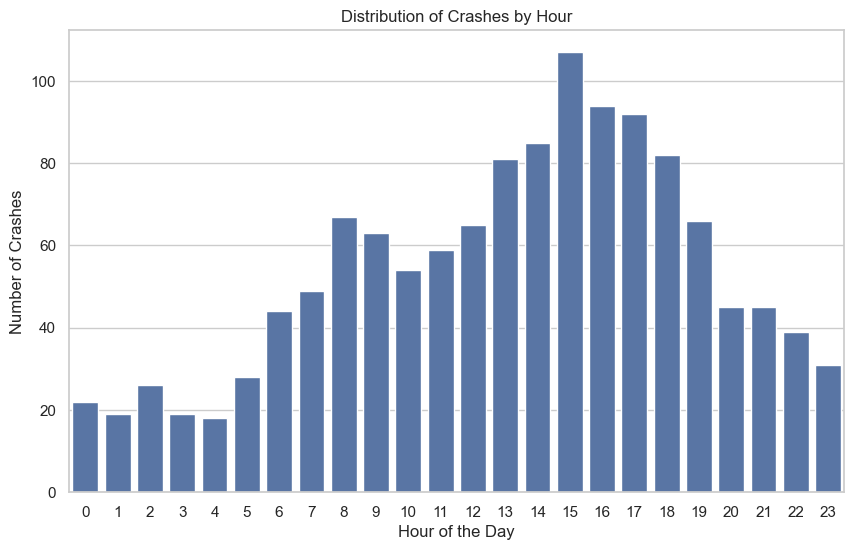

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DataFrame
df = pd.read_csv('traffic_crashes.csv')  

# Set the style using Seaborn
sns.set(style="whitegrid")

# Plot distribution of crashes by hour
plt.figure(figsize=(10, 6))
sns.countplot(x='crash_hour', data=df)
plt.title('Distribution of Crashes by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crashes')
plt.show()


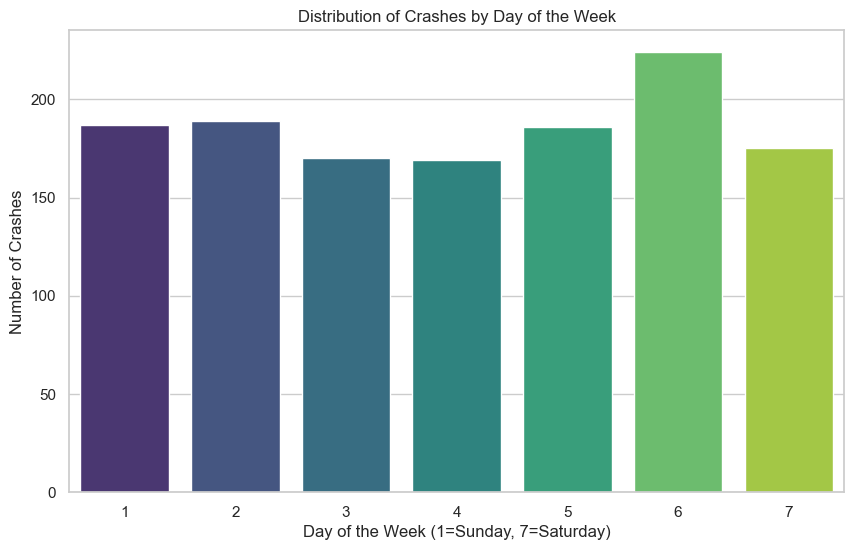

In [172]:
plt.figure(figsize=(10, 6))
sns.countplot(x='crash_day_of_week', data=df, palette='viridis')
plt.title('Distribution of Crashes by Day of the Week')
plt.xlabel('Day of the Week (1=Sunday, 7=Saturday)')
plt.ylabel('Number of Crashes')
plt.show()

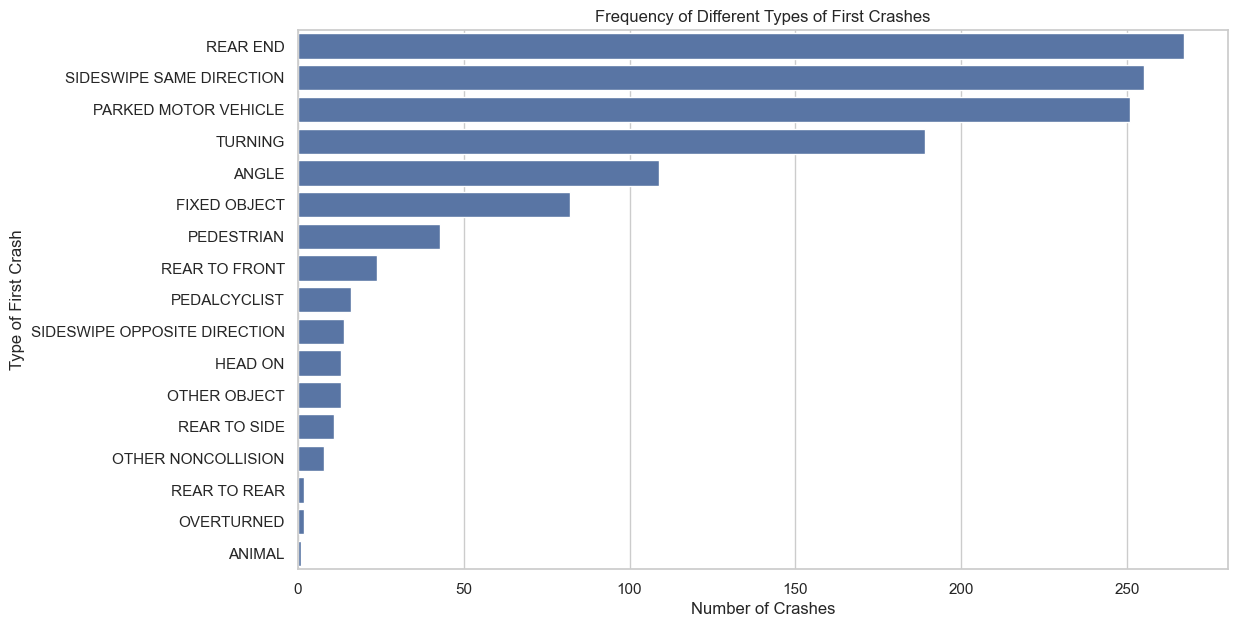

In [173]:
plt.figure(figsize=(12, 7))
sns.countplot(y='first_crash_type', data=df, order = df['first_crash_type'].value_counts().index)
plt.title('Frequency of Different Types of First Crashes')
plt.xlabel('Number of Crashes')
plt.ylabel('Type of First Crash')
plt.show()

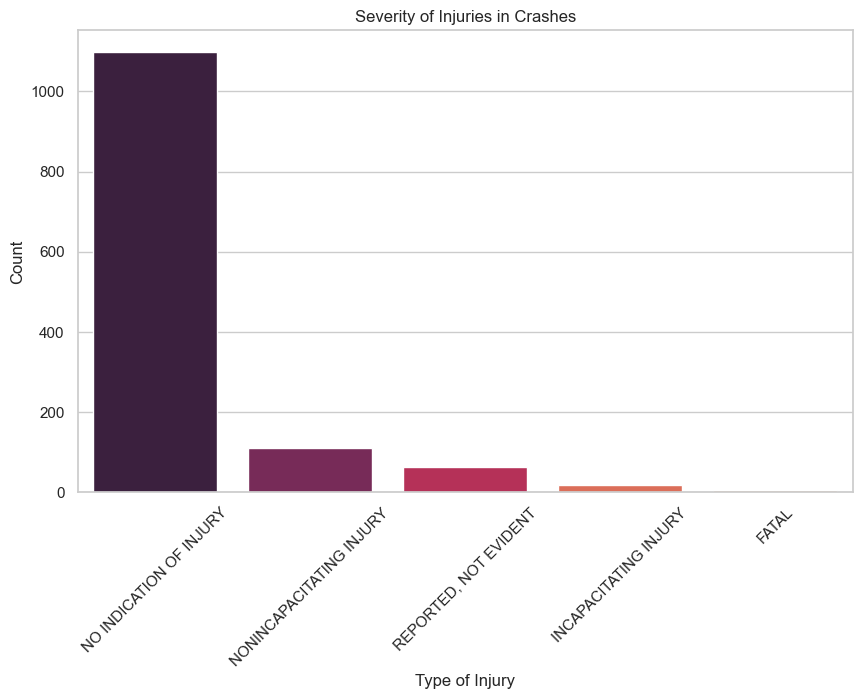

In [174]:
plt.figure(figsize=(10, 6))
sns.countplot(x='most_severe_injury', data=df, order = df['most_severe_injury'].value_counts().index, palette='rocket')
plt.title('Severity of Injuries in Crashes')
plt.xlabel('Type of Injury')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

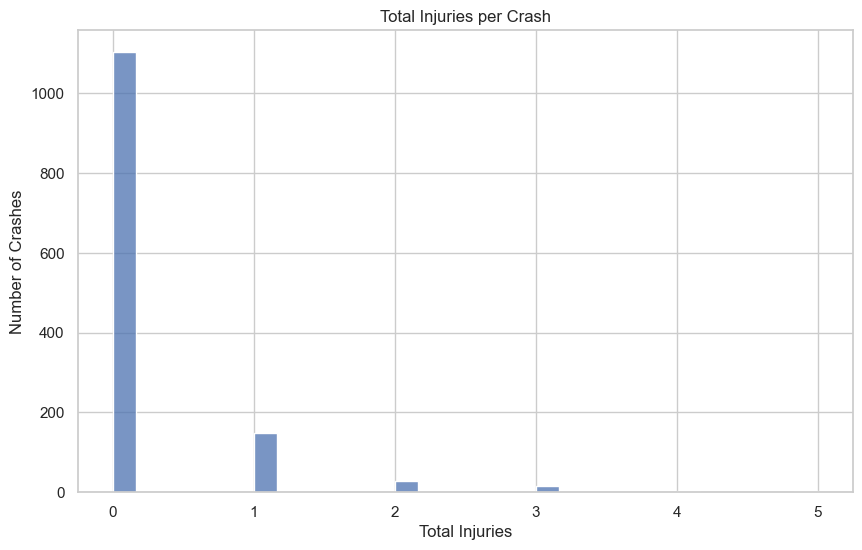

In [175]:
df['total_injuries'] = df[['injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident']].sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(df['total_injuries'], bins=30, kde=False)
plt.title('Total Injuries per Crash')
plt.xlabel('Total Injuries')
plt.ylabel('Number of Crashes')
plt.show()

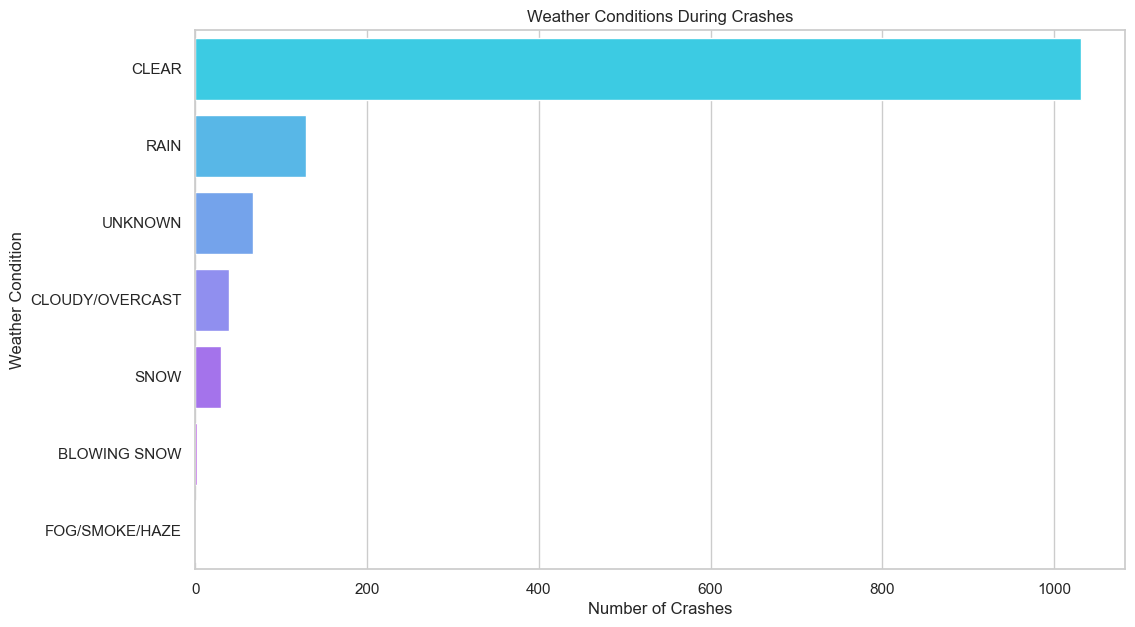

In [176]:
plt.figure(figsize=(12, 7))
sns.countplot(y='weather_condition', data=df, order = df['weather_condition'].value_counts().index, palette='cool')
plt.title('Weather Conditions During Crashes')
plt.xlabel('Number of Crashes')
plt.ylabel('Weather Condition')
plt.show()

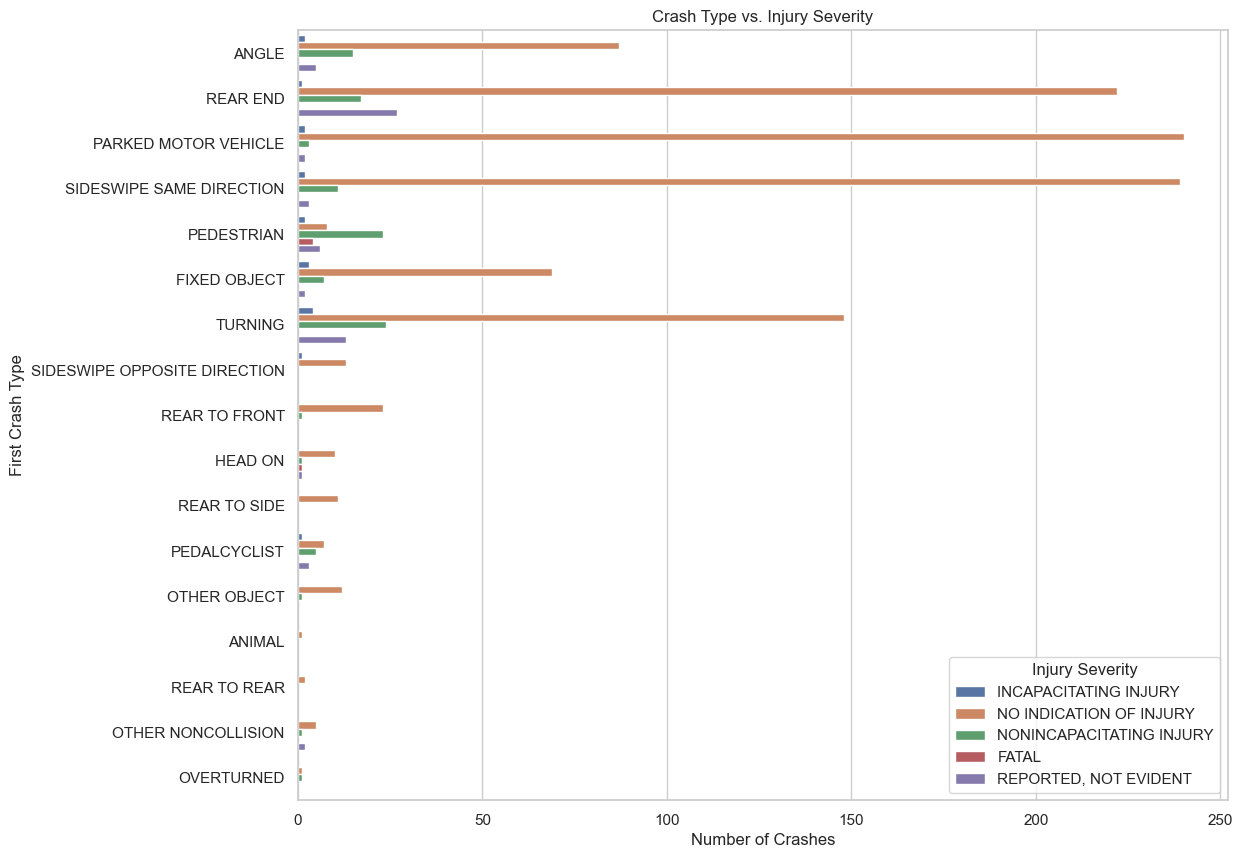

In [177]:
plt.figure(figsize=(12, 10))
sns.countplot(y='first_crash_type', hue='most_severe_injury', data=df)
plt.title('Crash Type vs. Injury Severity')
plt.xlabel('Number of Crashes')
plt.ylabel('First Crash Type')
plt.legend(title='Injury Severity', loc='best')
plt.show()

Visualizations - Motor Vehicle Collisions

In [178]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pg_params = {
    "host": "localhost",
    "database": "postgres",
    "user": "postgres",
    "password": "Thanksgiving2024"
}

conn = psycopg2.connect(**pg_params)
warnings.filterwarnings("ignore")
# Query data from the traffic_crashes table
query = "SELECT * FROM motor_vehicle_collisions;"
new_traffic_data = pd.read_sql(query, conn)

conn.close()
# Saving the DataFrame to a CSV file
csv_file_path = 'motor_vehicle_collisions.csv'
new_traffic_data.to_csv(csv_file_path, index=False)

In [179]:
data = pd.read_csv(csv_file_path)
# Display the first few rows of the data
print(data.head())

# Display basic statistics of numerical columns
print(data.describe())


                        _id           crash_date crash_time  \
0  6632736694e1970353869e87  2021-09-11T00:00:00       2:39   
1  6632736694e1970353869e88  2022-03-26T00:00:00      11:45   
2  6632736694e1970353869e89  2022-06-29T00:00:00       6:55   
3  6632736694e1970353869e8a  2021-09-11T00:00:00       9:35   
4  6632736694e1970353869e8b  2021-12-14T00:00:00       8:13   

            on_street_name off_street_name  number_of_persons_injured  \
0    WHITESTONE EXPRESSWAY       20 AVENUE                          2   
1  QUEENSBORO BRIDGE UPPER             NaN                          1   
2       THROGS NECK BRIDGE             NaN                          0   
3                      NaN             NaN                          0   
4          SARATOGA AVENUE  DECATUR STREET                          0   

   number_of_persons_killed  number_of_pedestrians_injured  \
0                         0                              0   
1                         0                              0

In [180]:
# Display information about the DataFrame structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            1300 non-null   object 
 1   crash_date                     1300 non-null   object 
 2   crash_time                     1300 non-null   object 
 3   on_street_name                 955 non-null    object 
 4   off_street_name                592 non-null    object 
 5   number_of_persons_injured      1300 non-null   int64  
 6   number_of_persons_killed       1300 non-null   int64  
 7   number_of_pedestrians_injured  1300 non-null   int64  
 8   number_of_pedestrians_killed   1300 non-null   int64  
 9   number_of_cyclist_injured      1300 non-null   int64  
 10  number_of_cyclist_killed       1300 non-null   int64  
 11  number_of_motorist_injured     1300 non-null   int64  
 12  number_of_motorist_killed      1300 non-null   i

In [181]:
# Check for missing values in the DataFrame
missing_values = data.isnull().sum()
print(missing_values)

_id                                 0
crash_date                          0
crash_time                          0
on_street_name                    345
off_street_name                   708
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1       3
contributing_factor_vehicle_2     277
collision_id                        0
vehicle_type_code1                 17
vehicle_type_code2                418
borough                           464
zip_code                          465
latitude                           85
longitude                          85
location                         1300
cross_street_name                 955
contributing_factor_vehicle_3    1178
vehicle_type_code_3              1192
contributing

In [182]:
# Handle missing values for numerical columns
numerical_columns = data.select_dtypes(include='number')
mean_values = numerical_columns.mean()
data.fillna(mean_values, inplace=True)

# Handle missing values for categorical columns
categorical_columns = data.select_dtypes(exclude='number').columns
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

# Check if there are any missing values after handling them
missing_values_after_handling = data.isnull().sum()
if missing_values_after_handling.sum() > 0:
    print("There are still missing values in the DataFrame:")
    print(missing_values_after_handling)
else:
    print("No missing values in the DataFrame after handling.")


There are still missing values in the DataFrame:
_id                                 0
crash_date                          0
crash_time                          0
on_street_name                      0
off_street_name                     0
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1       0
contributing_factor_vehicle_2       0
collision_id                        0
vehicle_type_code1                  0
vehicle_type_code2                  0
borough                             0
zip_code                            0
latitude                            0
longitude                           0
location                         1300
cross_street_name                   0
contributing_factor_vehicle_3       0
v

In [183]:
# Calculate the sum of missing values in each column
Vehicle_Collisions_missing_values = data.isna().sum()

# Display the sum of missing values
print(Vehicle_Collisions_missing_values)

_id                                 0
crash_date                          0
crash_time                          0
on_street_name                      0
off_street_name                     0
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1       0
contributing_factor_vehicle_2       0
collision_id                        0
vehicle_type_code1                  0
vehicle_type_code2                  0
borough                             0
zip_code                            0
latitude                            0
longitude                           0
location                         1300
cross_street_name                   0
contributing_factor_vehicle_3       0
vehicle_type_code_3                 0
contributing

In [184]:
# List of columns to remove
columns_removed = ['_id', 'location']


data = data.drop(columns=columns_removed, errors='ignore')

In [185]:
# Calculate the sum of missing values in each column
Vehicle_Collisions_missing_values = data.isna().sum()

# Display the sum of missing values
print(Vehicle_Collisions_missing_values)

crash_date                       0
crash_time                       0
on_street_name                   0
off_street_name                  0
number_of_persons_injured        0
number_of_persons_killed         0
number_of_pedestrians_injured    0
number_of_pedestrians_killed     0
number_of_cyclist_injured        0
number_of_cyclist_killed         0
number_of_motorist_injured       0
number_of_motorist_killed        0
contributing_factor_vehicle_1    0
contributing_factor_vehicle_2    0
collision_id                     0
vehicle_type_code1               0
vehicle_type_code2               0
borough                          0
zip_code                         0
latitude                         0
longitude                        0
cross_street_name                0
contributing_factor_vehicle_3    0
vehicle_type_code_3              0
contributing_factor_vehicle_4    0
vehicle_type_code_4              0
contributing_factor_vehicle_5    0
vehicle_type_code_5              0
dtype: int64


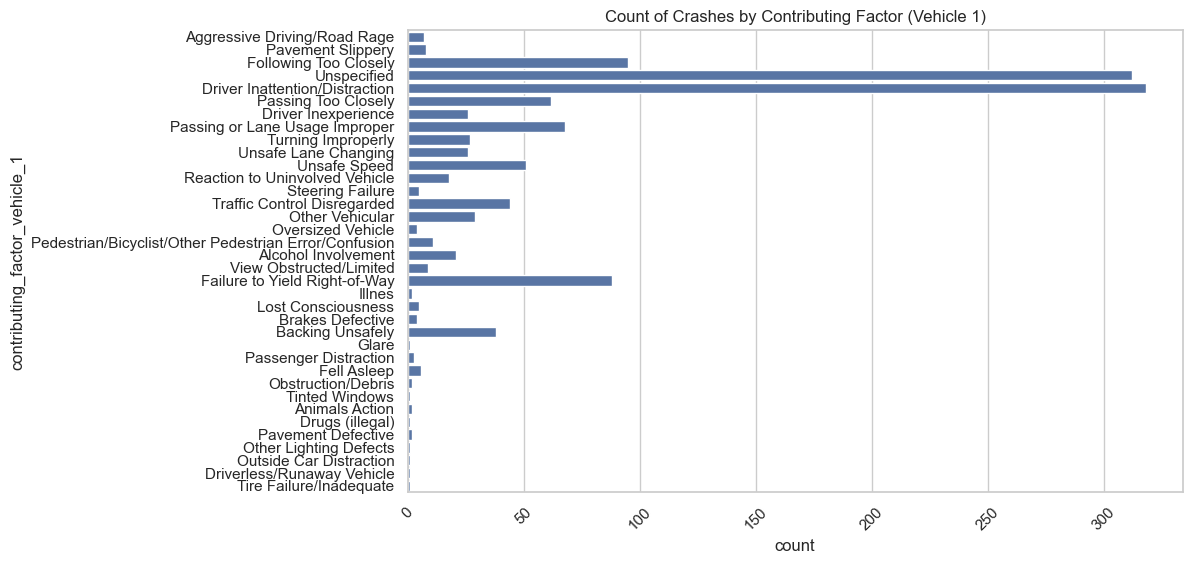

In [186]:
# Plot count plots for categorical variables
plt.figure(figsize=(10, 6))
sns.countplot(data['contributing_factor_vehicle_1'])
plt.title('Count of Crashes by Contributing Factor (Vehicle 1)')
plt.xticks(rotation=45)
plt.show()


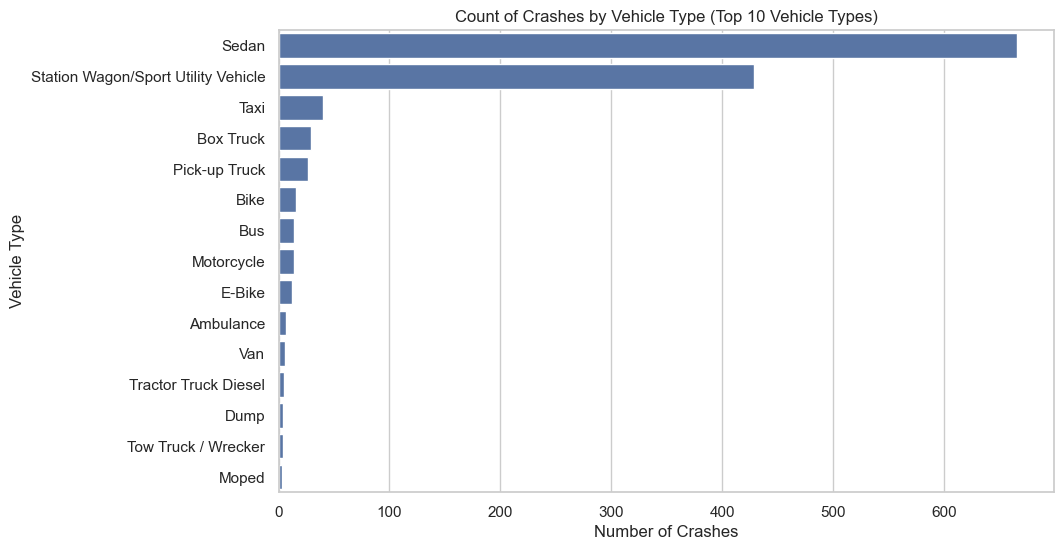

In [187]:
# Count the occurrences of each vehicle type and sort them in descending order
vehicle_counts = data['vehicle_type_code1'].value_counts().nlargest(15)

# Create a horizontal bar plot for the top 10 vehicle types with the most crashes
plt.figure(figsize=(10, 6))
sns.barplot(y=vehicle_counts.index, x=vehicle_counts.values)
plt.title('Count of Crashes by Vehicle Type (Top 10 Vehicle Types)')
plt.ylabel('Vehicle Type')  # Adjust label for clarity
plt.xlabel('Number of Crashes')  # Adjust label for clarity
plt.show()


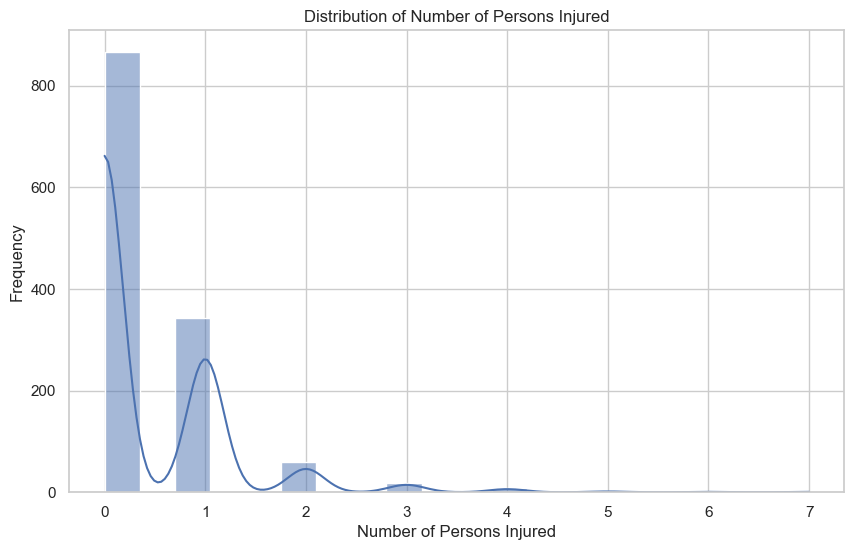

In [188]:
# histogram for numerical variables
plt.figure(figsize=(10, 6))
sns.histplot(data['number_of_persons_injured'], bins=20, kde=True)
plt.title('Distribution of Number of Persons Injured')
plt.xlabel('Number of Persons Injured')
plt.ylabel('Frequency')
plt.show()


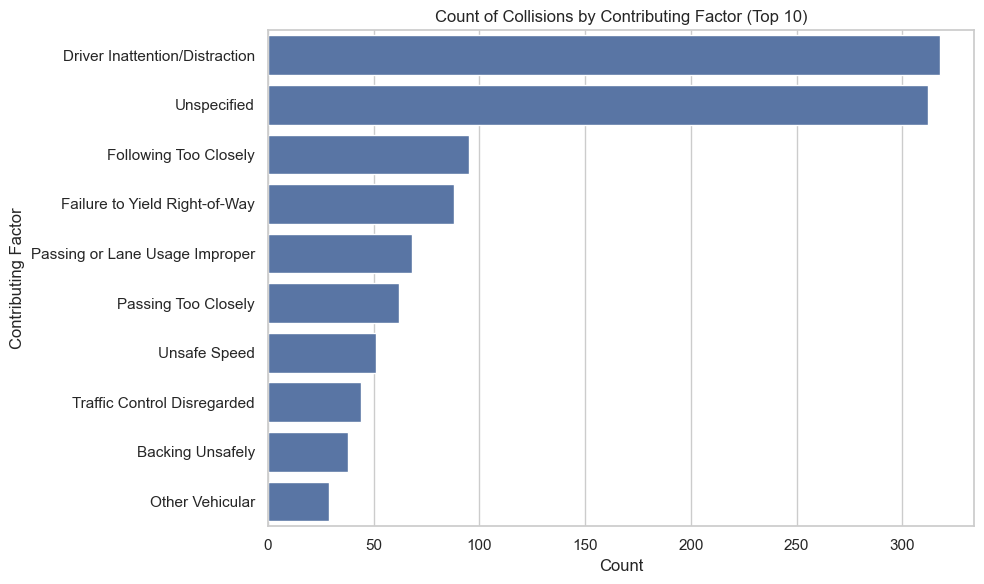

In [189]:
# Bar plot showing count of collisions by contributing factor
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='contributing_factor_vehicle_1', order=data['contributing_factor_vehicle_1'].value_counts().index[:10])
plt.title('Count of Collisions by Contributing Factor (Top 10)')
plt.xlabel('Count')
plt.ylabel('Contributing Factor')
plt.tight_layout()
plt.show()

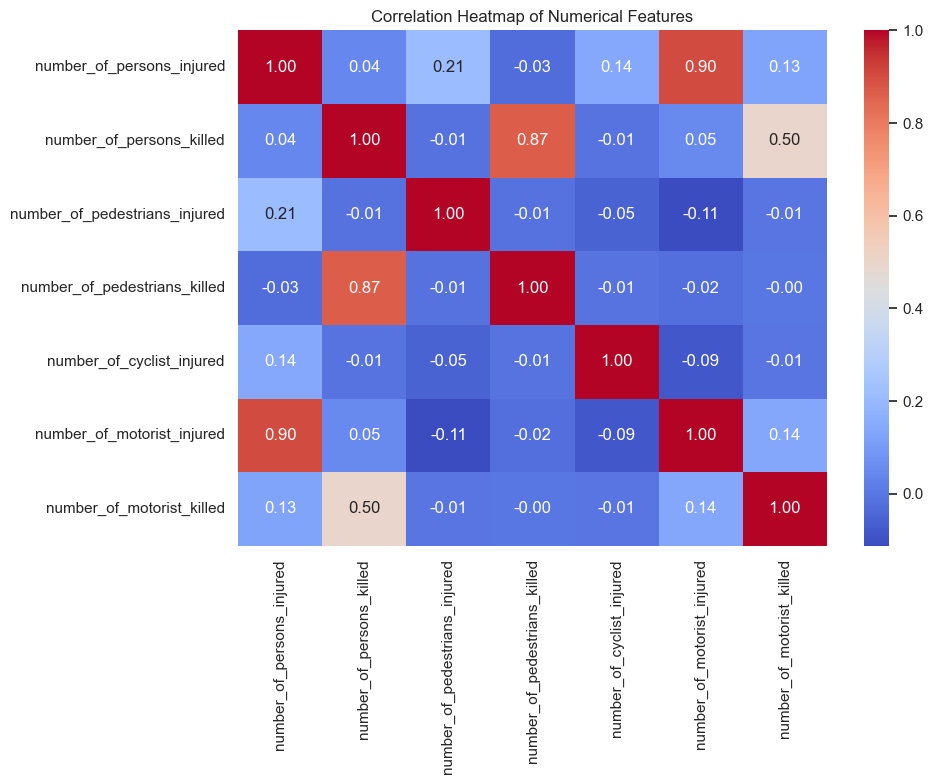

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

num_features = ['number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured',
                'number_of_pedestrians_killed', 'number_of_cyclist_injured',
                'number_of_motorist_injured', 'number_of_motorist_killed']
# Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
corr = data[num_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

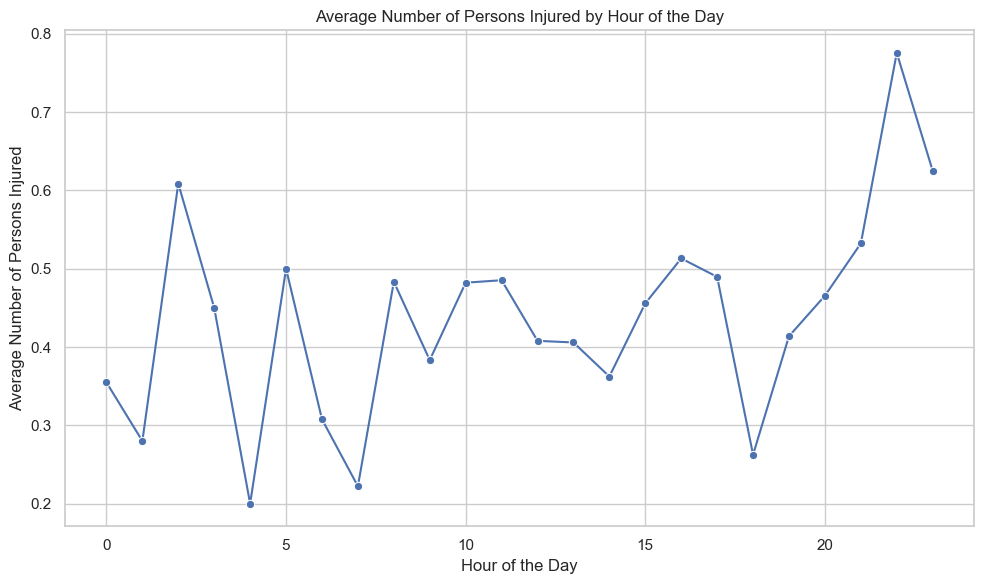

In [192]:

# Convert 'crash_time' to datetime and extract the hour if not already done
data['crash_time'] = pd.to_datetime(data['crash_time']).dt.hour

# Aggregate the data to get the mean number of persons injured for each hour
hourly_injuries = data.groupby('crash_time')['number_of_persons_injured'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=hourly_injuries, x='crash_time', y='number_of_persons_injured', marker='o')  

plt.title('Average Number of Persons Injured by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Persons Injured')
plt.grid(True)
plt.tight_layout()
plt.show()


In [193]:
! pip install folium


In [194]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Load your data into a DataFrame

data = pd.read_csv('motor_vehicle_collisions.csv') 

# Copy the data and select only the 'LATITUDE' and 'LONGITUDE' columns
df_lat = data.copy()
df_lat = df_lat[['latitude', 'longitude']]

# Remove rows where 'LATITUDE' or 'LONGITUDE' might be missing
df_lat = df_lat.dropna(subset=['latitude', 'longitude'])


# Calculate the mean latitude and longitude to center the map
latitude = df_lat["latitude"].mean()
longitude = df_lat["longitude"].mean()

# Create a map centered around the average location
map = folium.Map(location=[latitude, longitude], zoom_start=10)

# Adding a marker cluster to the map
marker_cluster = MarkerCluster().add_to(map)


for _, row in df_lat.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        icon=None  
    ).add_to(marker_cluster)

# Display the map
map
